# Mateusz Gierlach
## Analiza danych + budowa modelu

Ponizej przedstawiam analiza danych oraz zbudowanie modelu predykcyjnego dla problemu regresji zwiazanej z przewidzeniem cen mieszkan dla danych z house.csv.

Analize przeprowadzam w nastepujacej kolejnosci:
1. Importuje dane oraz potrzebne pakiety
2. Dokonuje wstepnego przegladu danych
3. "Naprawiam" typy danych, ktore nie pasuja
4. Dokonuje analizy statystycznej danych i wyciagam z niej wnioski
5. Analizuje brakujace dane
6. Analizuje wartosci odstajace
7. Analizuje korelacje miedzy zmiennymi niedecyzyjnymi, a ta decyzyjna
8. Dziele dane na treningowe i testowe w stosunku 90-10
9. Buduje model oparty o Gradient Boosting
10. Sprawdzam dokladnosc predykcji, dla danych ktorym nie podaje 'price'

Najlepsza dokladnosc mojego modelu, ktora udalo mi sie uzyskac to 90%.


## Biblioteki i wstepny przeglad danych

Import pakietow.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

Wczytanie danych.

In [2]:
data = pd.read_csv("house.csv")

Sprawdzenie rozmiaru danych.
Mam 21613 rekordow opisanych 21 kolumnami.

In [3]:
data.shape

(21613, 21)

Sprawdzenie jakie mam kolumny.
Sprawdzenie z plikiem .pdf opisujacym zadanie czy wszystko sie zgadza.

In [4]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Rzut okiem na format danych w pierwszych 5 rekordach.

In [5]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Obrobka danych

Zauwazmy, ze format nie wszystkich danych jest zgodny z plikiem opisujacym zadanie.

Sprawdzam obecne typy danych dla kolumn.

In [6]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Zmieniam typy danych kolumn, dla ktorych jest to potrzebne. Tutaj zajmuje sie tymi, ktore zostaly wypisane w pliku .pdf jako te, ktore nalezy zutylizowac.

In [7]:
# zostawiam tylko pierwszych 8 znakow, nie ma potrzeby przechowywac wiecej
data['date'] = data['date'].str[0:8].astype(object)

# liczba lazienek zawsze bedzie int-em
data['bathrooms'] = data['bathrooms'].astype(np.int64)

# pola powierzchni powinny byc float-ami
data['sqft_living'] = data['sqft_living'].astype(np.float64)
data['sqft_lot'] = data['sqft_lot'].astype(np.float64)

# ilosc pieter zawsze bedzie int-em
data['floors'] = data['floors'].astype(np.int64)

# dom moze byc przy wodzie lub nie - tak wiec zmienna boolowska
data['waterfront'] = data['waterfront'].astype(np.bool_)

Ale zmieniam tez typy dla kolumn, ktorych nie trzeba bylo koniecznie utylizowac, poniewaz wykorzystanie wszystkich danych pozwala mi zbudowac lepszy model.

Zobaczmy typy danych po zmianie.

In [8]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms          int64
sqft_living      float64
sqft_lot         float64
floors             int64
waterfront          bool
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Wyswietlam dane statystyczne dla kazdej kolumny, aby zobaczyc trendy w tych danych.

In [9]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,1.749734,2079.899736,1.510697e+04,1.446213,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.734873,918.440897,4.142051e+04,0.551894,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.000000,1427.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.000000,1910.000000,7.618000e+03,1.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.000000,2550.000000,1.068800e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Zauwazmy kilka rzeczy:
* nie ma brakujacych danych typu NaN - wszystkie kolumny maja count = 21613
* id jest tylko dla okreslania rekordow, nie bedziemy uzywac w modelowaniu
* niektore mieszkania nie maja ani jednej lazienki czy ani jednej sypialni - wydaje sie to bledem, ale byc moze sa takie domy, wiec nie mam pelnej pewnosci, aby traktowac je jako dane brakujace
* zmienne int-owe view, condition, grade sa okreslone poprawnie
* w wiekszosci rekordow nie mamy danych na temat roku renowacji (yr_renovated) - zamienimy to na zmienna boolowska - albo zostal wyremontowany albo nie, nie ma znaczenia kiedy
* zapisanie lat i long (danych geograficznych) jako float-y ma sens, poniewaz liczby blisko siebie mowia o podobnej lokalizacji, co moze wplywac na cene
* zipcode w postaci numerycznej nie ma zadnego sensu, poniewaz nie ma bezposredniego powiazania miedzy kodami pocztowymi a dokladnym polozeniem domu; nie mam tez narzedzi by przerobic to na zmienna mapowa; dlatego zipcode nie bedzie brany pod uwage; w pozniejszej czesci usune ta kolumne

Ogolnie: poza kilkoma miejscami na dodatkowy preprocessing danych, nie mamy danych brakujacych, ktore musimy uzupelniac.

Sprawdzmy ile mamy rekordow, dla ktorych podany jest rok renowacji (yr_renovated).

In [10]:
data[data['yr_renovated'] != 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,20141209,538000.0,3,2,2570.0,7242.0,2,False,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
35,9547205180,20140613,696000.0,3,2,2300.0,3060.0,1,False,0,...,8,1510,790,1930,2002,98115,47.6827,-122.310,1590,3264
95,1483300570,20140908,905000.0,4,2,3300.0,10250.0,1,False,0,...,7,2390,910,1946,1991,98040,47.5873,-122.249,1950,6045
103,2450000295,20141007,1088000.0,3,2,2920.0,8113.0,2,False,0,...,8,2920,0,1950,2010,98004,47.5814,-122.196,2370,8113
115,3626039325,20141121,740500.0,3,3,4380.0,6350.0,2,False,0,...,8,2780,1600,1900,1999,98117,47.6981,-122.368,1830,6350
125,4389200955,20150302,1450000.0,4,2,2750.0,17789.0,1,False,0,...,8,1980,770,1914,1992,98004,47.6141,-122.212,3060,11275
158,8029200135,20141113,247000.0,3,2,1270.0,7198.0,1,False,0,...,7,1270,0,1916,2013,98022,47.2086,-121.996,1160,7198
209,6300000550,20140717,464000.0,6,3,2300.0,3404.0,2,False,0,...,7,1600,700,1920,1994,98133,47.7067,-122.343,1560,1312
216,46100204,20150221,1505000.0,5,3,3300.0,33474.0,1,False,3,...,9,1870,1430,1957,1991,98040,47.5673,-122.210,3836,20953
230,8096000060,20150413,655000.0,2,1,1450.0,15798.0,2,True,4,...,7,1230,220,1915,1978,98166,47.4497,-122.375,2030,13193


Mamy 914 takich rekordow. Tak jak pisalem wczesniej, zamieniam ta kolumne na boolowska.

In [11]:
data.yr_renovated[data['yr_renovated'] != 0] = 1
data['yr_renovated'] = data['yr_renovated'].astype(np.bool_)

Sprawdzenie jak sie rozkladaja wartosci w 'price'.

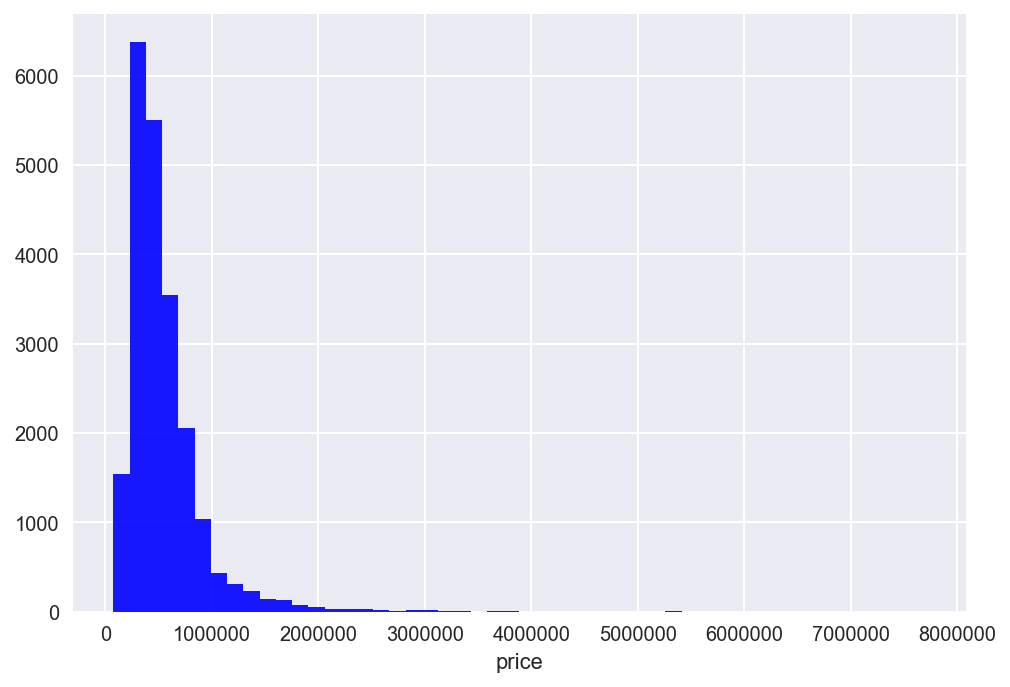

In [12]:
sns.distplot(data['price'], kde = False, color = 'b', hist_kws={'alpha': 0.9})

Sprawdzmy jakie jest skrzywienie.

In [13]:
print("Skrzywienie: %f" % data['price'].skew())

Skrzywienie: 4.024069


Skrzywienie jest spore, pozniej trzeba bedzie zlogarytmizowac.

### Wartosci odstajace

Szukam wartosci odstajacych dla danych z kolumn. W tym celu rysuje scatterploty dla kolejnych kolumn danych, gdzie na osi y zawsze jest 'price' - cena domu.

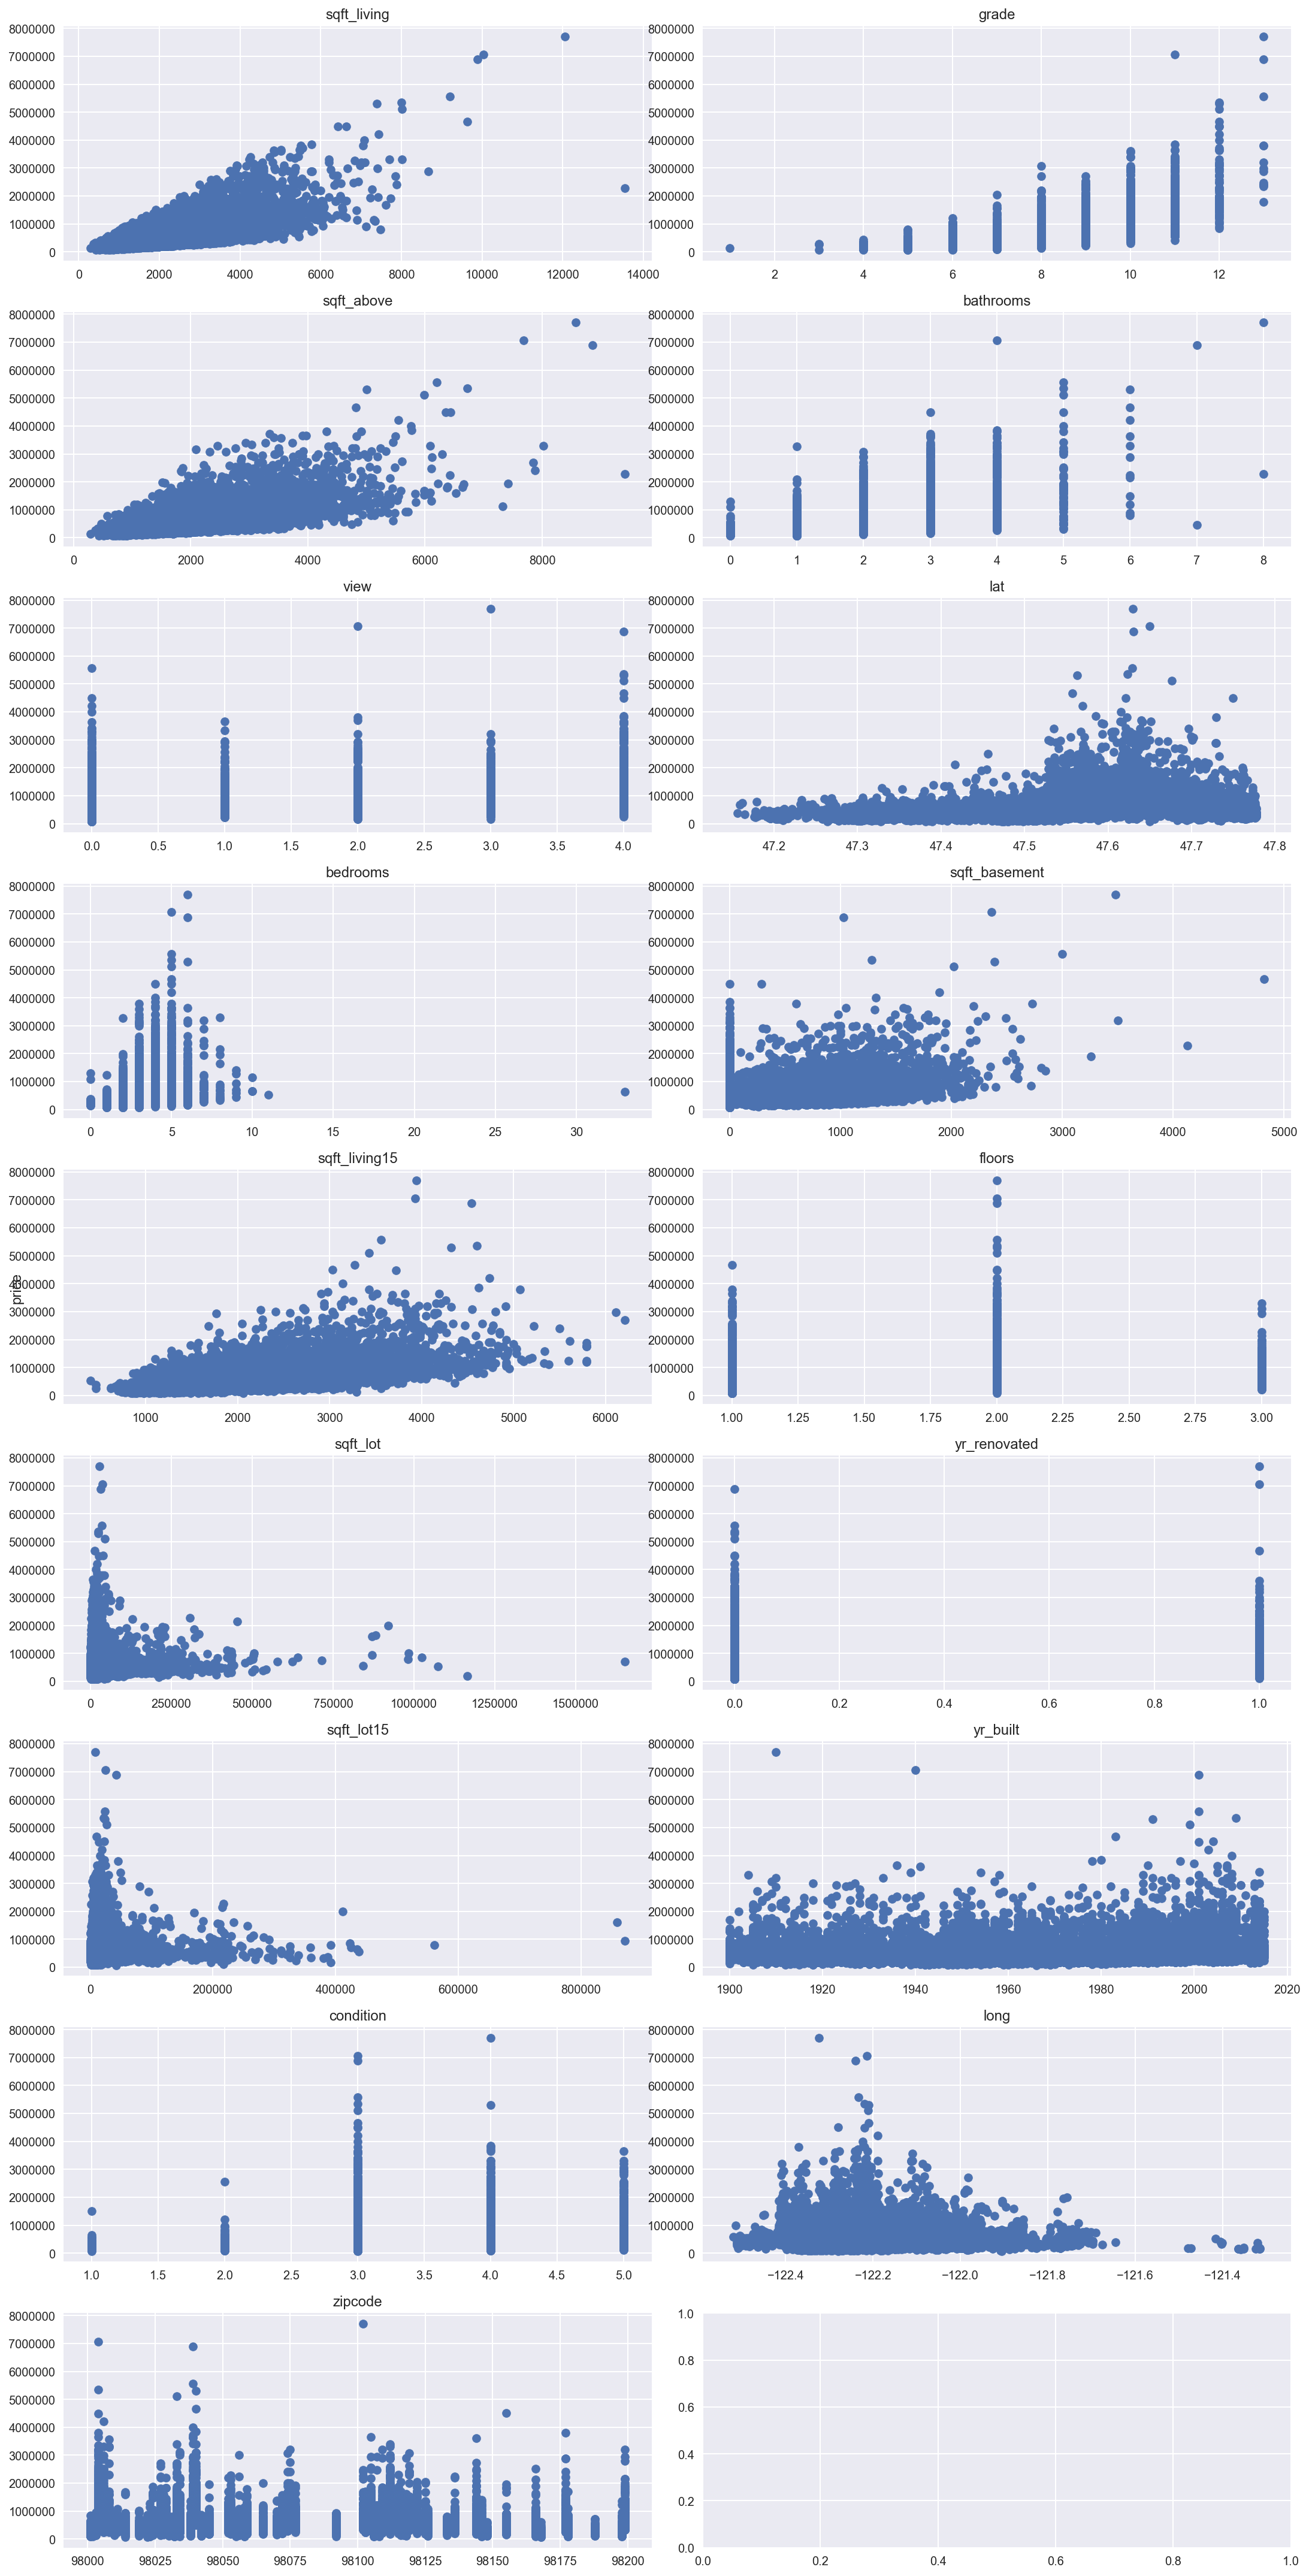

In [14]:
plt.figure(1)
f, axarr = plt.subplots(9, 2, figsize=(15, 30))

axarr[0, 0].scatter(data.sqft_living.values, data.price.values)
axarr[0, 0].set_title('sqft_living')

axarr[0, 1].scatter(data.grade.values, data.price.values)
axarr[0, 1].set_title('grade')

axarr[1, 0].scatter(data.sqft_above.values, data.price.values)
axarr[1, 0].set_title('sqft_above')

axarr[1, 1].scatter(data.bathrooms.values, data.price.values)
axarr[1, 1].set_title('bathrooms')

axarr[2, 0].scatter(data.view.values, data.price.values)
axarr[2, 0].set_title('view')

axarr[2, 1].scatter(data.lat.values, data.price.values)
axarr[2, 1].set_title('lat')

axarr[3, 1].scatter(data.sqft_basement.values, data.price.values)
axarr[3, 1].set_title('sqft_basement')

axarr[3, 0].scatter(data.bedrooms.values, data.price.values)
axarr[3, 0].set_title('bedrooms')

axarr[4, 1].scatter(data.floors.values, data.price.values)
axarr[4, 1].set_title('floors')

axarr[4, 0].scatter(data.sqft_living15.values, data.price.values)
axarr[4, 0].set_title('sqft_living15')

axarr[5, 1].scatter(data.yr_renovated.values, data.price.values)
axarr[5, 1].set_title('yr_renovated')

axarr[5, 0].scatter(data.sqft_lot.values, data.price.values)
axarr[5, 0].set_title('sqft_lot')

axarr[6, 0].scatter(data.sqft_lot15.values, data.price.values)
axarr[6, 0].set_title('sqft_lot15')

axarr[6, 1].scatter(data.yr_built.values, data.price.values)
axarr[6, 1].set_title('yr_built')

axarr[7, 0].scatter(data.condition.values, data.price.values)
axarr[7, 0].set_title('condition')


axarr[8, 0].scatter(data.zipcode.values, data.price.values)
axarr[8, 0].set_title('zipcode')

axarr[7, 1].scatter(data.long.values, data.price.values)
axarr[7, 1].set_title('long')



f.text(-0.01, 0.5, 'price', va='center', rotation='vertical', fontsize = 12)
plt.tight_layout()
plt.show()

Eliminuje wartosci odstajace, na bazie powyzszych wykresow. Pozostale zmienne pozostawiam bez zmian.

In [15]:
data = data[data.sqft_living < 9000]
data = data[data.sqft_above < 7000]
data = data[data.bedrooms < 15]
data = data[data.sqft_basement < 3000]
data = data[data.sqft_living15 < 6000]

### Korelacja zmiennych

Tworze wizualna macierz korelacji zmiennych liczbowych (bez id), aby sprawdzic korelacje miedzy zmiennymi. A w szczegolnosci korelacje z 'price'.

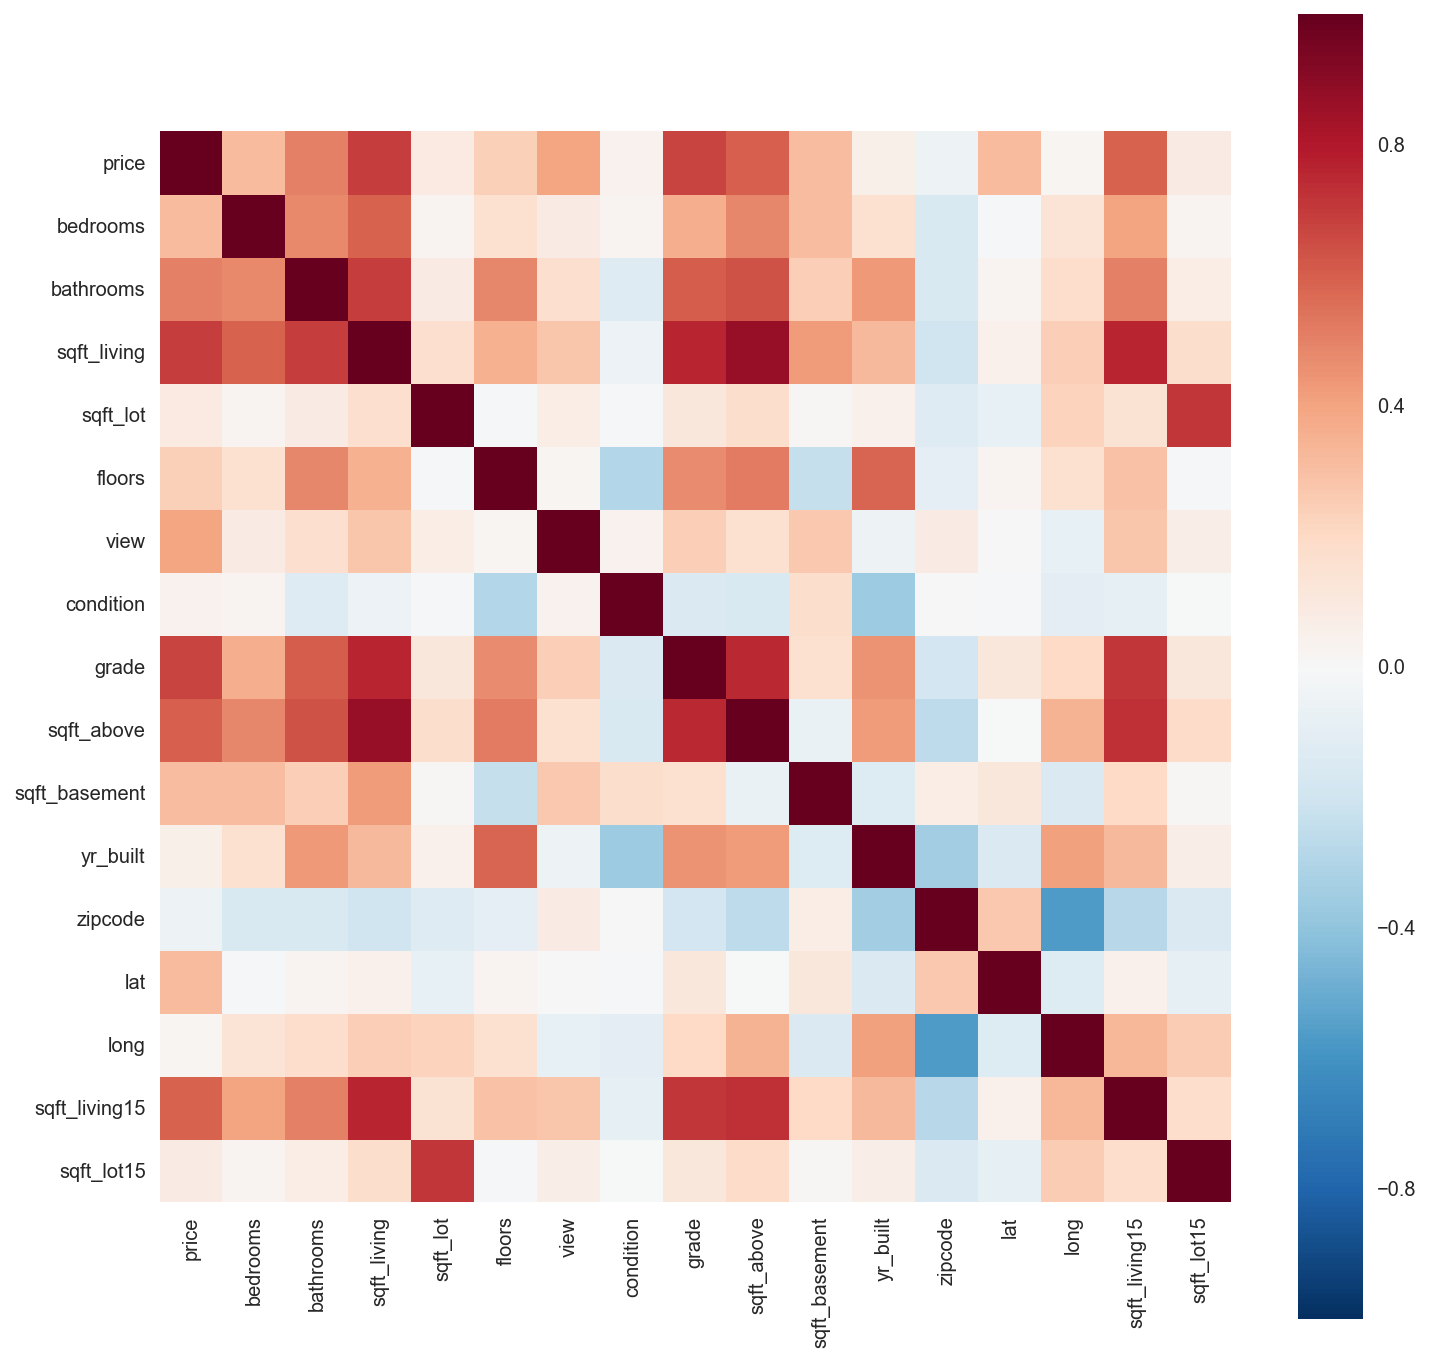

In [16]:
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)

Wyswietlam liste zmiennych i ich korelacji z cena. Im wieksza wartosc, tym scislejsza korelacja.

In [17]:
cor_dict = corr['price'].to_dict()
del cor_dict['price']
print("Korelacja zmiennych z 'price':\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

List the numerical features decendingly by their correlation with price:

sqft_living: 	0.6936638407754511
grade: 	0.6727556387486511
sqft_above: 	0.5978761170483787
sqft_living15: 	0.5908009693050418
bathrooms: 	0.5026108932623062
view: 	0.3965749083087306
lat: 	0.31679917121543033
bedrooms: 	0.31564857596494633
sqft_basement: 	0.31196678649933923
floors: 	0.24162604809784896
sqft_lot: 	0.0885137533625326
sqft_lot15: 	0.08044841818879314
yr_built: 	0.055232562471269835
zipcode: 	-0.0519273670858071
condition: 	0.03930114969412607
long: 	0.02162337428724345


Jak pisalem wczesniej, usuwam kolumne 'zipcode'. Innymi moimi pomyslami w tym punkcie bylo usuniecie kolumn o lym skorelowaniu z cena, ale moje eksperymenty pokazaly, ze model mial najlepsza dokladnosc dla wiekszej liczby zmiennych.

In [18]:
data.drop('zipcode', axis=1, inplace=True)

Ostatnie sprawdzenie poprawnosci zmiennych przed przejsciem do budowania modelu.

In [19]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms          int64
sqft_living      float64
sqft_lot         float64
floors             int64
waterfront          bool
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated        bool
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## Model

In [20]:
# funkcja do obliczania bledu sredniokwadratowego i wspolczynnika determinacji
# wykorzystywana ponizej w train_test
def get_score(prediction, labels):    
    print('R2: {}'.format(r2_score(prediction, labels)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, labels))))

# obliczenia bledow predykcji dla zbiorow treningowych i testowych
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    print(estimator)
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    print("Test")
    get_score(prediction_test, y_tst)

W moich danych nie ma zbioru testowego podanego z gory, wszystkie dane zawieraja cene. Dlatego na razie nie dziele zbioru, podziele go samodzielnie dopiero przed uczeniem. Teraz zakladam ze zbiorem treningowym bedzie caly zbior data.

In [21]:
train = data
train_labels = train.pop('price') #podaje zmienna decyzyjna
features = train

Tak jak pisalem wczesniej, 'price' jest mocno skrzywione.

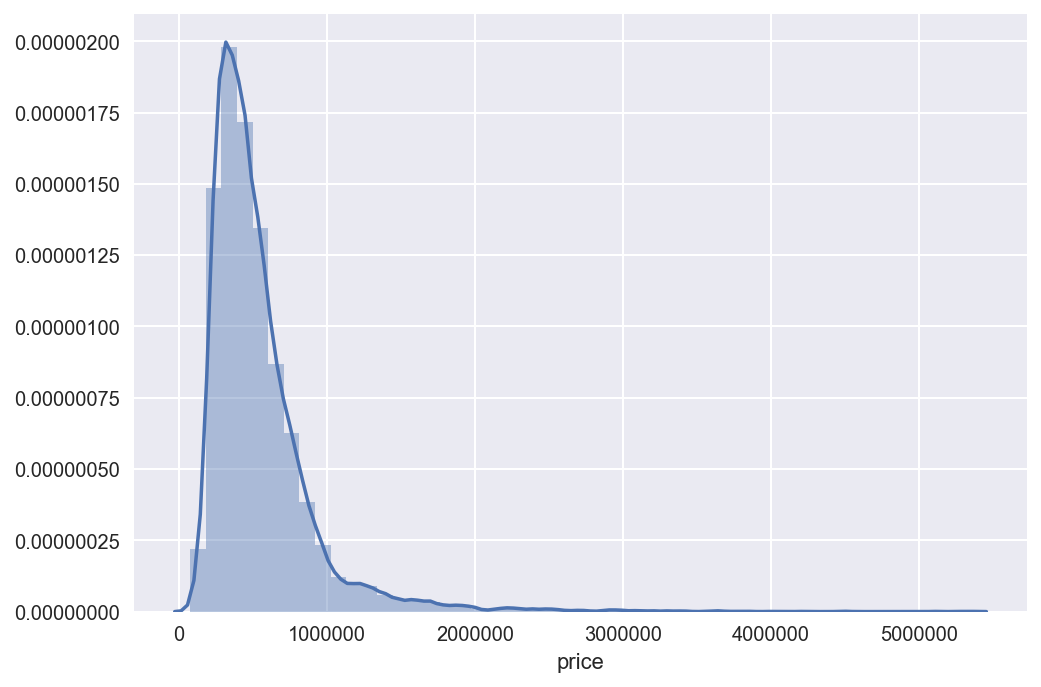

In [22]:
ax = sns.distplot(train_labels)

Logarytmizuje 'price' aby otrzymac bardziej rownolegle dane.

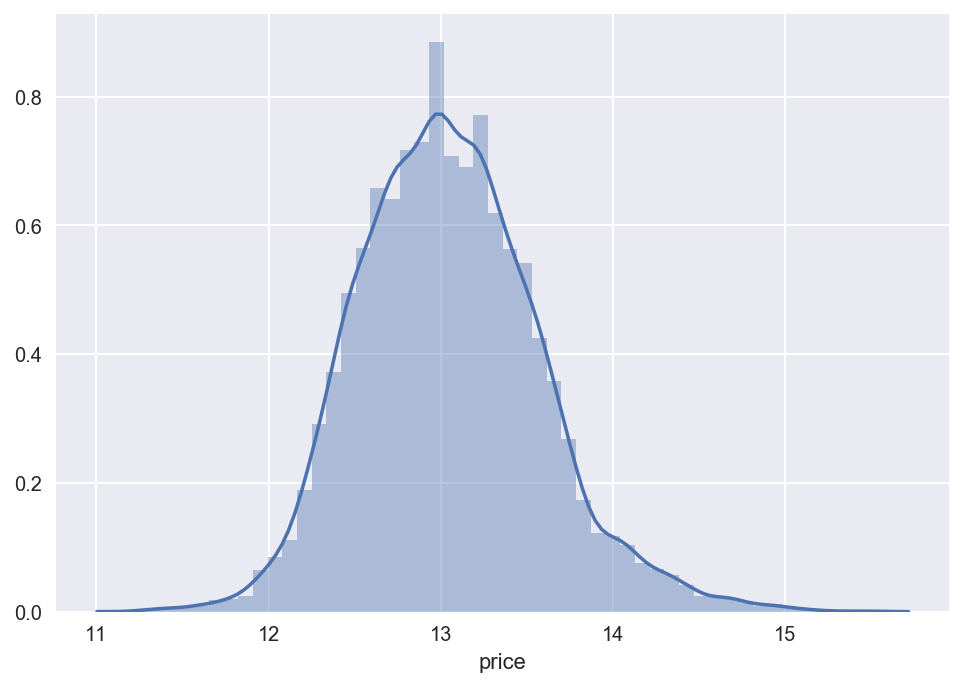

In [23]:
train_labels = np.log(train_labels)
ax = sns.distplot(train_labels)

Standaryzacja danych numerycznych. Danych kategorycznych w ogole nie mam, wiec nie musze ich dodatkowo przygotowywac.

In [24]:
numeric_features2 = features.loc[:,['bedrooms', 'bathrooms', 'sqft_living', 'floors',
                                    'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 
                                    'sqft_lot', 'condition', 'yr_built', 'yr_renovated', 'lat',
                                    'long', 'sqft_living15', 'sqft_lot15']]
numeric_features_standardized2 = (numeric_features2 - numeric_features2.mean())/numeric_features2.std()

Zamieniam dane numeryczne, wartosciami juz ustandaryzowanymi.

In [25]:
features_standardized = features.copy()
features_standardized.update(numeric_features_standardized2)

Podzial zmiennych zwyklych i ustandaryzowanych

In [26]:
train_features = features.drop('id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.drop('id', axis=1).select_dtypes(include=[np.number]).values

train_features_st = features_standardized.drop('id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.drop('id', axis=1).select_dtypes(include=[np.number]).values

In [27]:
# dodatkowe mieszanie
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

Podzial na zbior treningowy i testowy. Zbior testowy stanowi 10% calosci. Podzial 90-10 dal mi lepsze wyniki niz 80-20. Zjawisko przeuczenia nie wystapilo.

In [30]:
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

Budowanie pierwszego modelu - na bazie regresji Gradient Boosting

In [31]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
R2: 0.9127305437498177
RMSE: 0.14623358662789923
Test
R2: 0.8810862365445018
RMSE: 0.16935439553570994


Gotowy model do zastosowania na inne dane, ktore nie maja kolumny cenowej.

In [32]:
GB_model = GBest.fit(train_features, train_labels)

Obliczenie dokladnosci predykcji modelu gradientowego na moich podzielonych danych, uzywajac srednich z wynikow.

In [33]:
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Dokladnosc predykcji Gradient Boosting: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dokladnosc predykcji Gradient Boosting: 0.90 (+/- 0.01)
